# OpenStreetMap Sample Project Data Wrangling with MongoDB

For my analysis I chose the area around my home town, Schwabach, Germany. It is a small town in Bavaria in the vicinity of Nuremberg and Munich.

The osm file is 63 MByte big.
(http://www.openstreetmap.org/relation/62720)

The code for this project can be found on [GitHub](https://github.com/mbunse/OpenStreetMapProject).

## Data Cleaning Step
At first, I started to clean the data. 
### Cleaning Street Names
Unfortunately, German street names seem to be much less following a scheme than street names in the U.S.. Therefore, I chose to match each street name against a list of street name patterns. The list is as follows:

In [1]:
EXPECTED_PATTERNS = [r'\S-Straße$',
                     r'\S+straße$',
                     r'\bStraße$',
                     r'\S-Weg$',
                     r'weg$',
                     r'\bWeg$',
                     r'gasse',
                     r'\S-Gasse$',
                     r'\bGasse$',
                     r'Am\b',
                     r'^An der\b',
                     r'^An den\b',
                     r'^Auf der\b',
                     r'^Im\b',
                     r'^In der\b',
                     r'\S-Ring$',
                     r'\Sring$',
                     r'\Sallee$',
                     r'\Sgrund$',
                     r'\Sgraben',
                     r'\Sberg$',
                     r'\Splatz$',
                     r'\S-Platz$'
                    ]

Still, there are a lot of street names that do not match these patterns, but the list of remaining non-matching street name can be checked by eye. The following street names do not match the patterns:

`Hembacher Str
Zwischen den Brücken
Bergleite
Kiefernschlag
Doktorsbuck
Unterbaimbach
Föhrle
Schleusen
Backenfeldsteig
Wolkersdorfer Berg
Rennmühle
Wöhrwiese
Igelsdorf
Kienbühl
Rednitzhang
Häfnersgässchen
Eichenlöhlein
Mariensteig
Göckenhof
Kappelbergsteig
Poppenreuth
Sonnenleite
Nürnberger Leithe
Schloßsteig
Leinschlag
Nasbachtal
Lehmgrube
Mühlleite
Oberbaimbach
Unterer Grund
Worzeldorfer Kirchsteig
Schwarzacher Höhe
Ungerthal
Rosenhang
Waldsportanlage
Baumzeile
Bierleite
Limbachtal
Nordsteig
Harm
Zur Kläranlage
Waldwinkel
Unterer Kirchensteig
Hirschenzaun
In den Gärten
Schwarzach
Beim Biengarten
Wunneleite
Raubershof
Forstersbühl
Friedhofsgässchen
Oberer Grund
Boxlohe
Westend
Ellbogental
Greuth
Fleischbrücke
Kappadocia
Reichenbacher Wäldchen
Chausseehaus
Hänsenwöhr
Kaisersgarten
Bärensteig
Oberer Kirchensteig
Pfannestiel
Mainbachtal
Sieben Morgen
Hengdorf
Alte Gärtnerei
Finkenschlag
Sorgwiesen
Weihersmühle
RH 1
Wildenbergen
Weingäßchen`

RH 1 seems to be a strange road name, but I double checked that it is correct. The other street name that does not match the given patterns is `Hembacher Str`. This will be changed to `Hembacher Straße` before the import.

### House numbers
In the next step I have a look at the house numbers. A house number should be a number that might be followed by one or more letters. A single house number did not match the pattern: `ß20`. This might have been a typo. The number is changed to 28 according to the position of the house in the street.

### Amenity Tags
Then, I check the amenity tags. According to the Wikipedia page (https://wiki.openstreetmap.org/wiki/Key:amenity) I created a list of expected amenity labels. I find three labels that should be cleaned:
* `BRK_Zentrum_Schwabach`: this is actually a name of a red cross department. It is changed to `social centre`.
* `schoolyard`: will be a leisure tag with label `playground`, according to (https://wiki.openstreetmap.org/wiki/Tag:leisure%3Dplayground).
* `childcare`: will be replaced by `kindergarten`.

## Analyzing the Data
After loading the processed data into a MongoDB database, I can now run some queries, to find out some figures about the region around Schwabach.

At first, I prepare some methods to load

In [2]:
import pprint

def get_db(db_name):
    """ get a handle to the database """
    from pymongo import MongoClient
    client = MongoClient('localhost:27017')
    return client[db_name]

def make_pipeline():
    """ cosntruct pipeline to analyze data """
    req_pipeline = [{"$match": {"sport": {"$exists":1}}},
                    {"$group": {"_id": "$sport", "count": {"$sum": 1}}},
                    {"$sort": {"count": -1}}
                   ]
    return req_pipeline

def aggregate(db_handle, pipeline):
    """ run aggregation on db """
    return [doc for doc in db_handle.schwabach.aggregate(pipeline)]

DB_HANDLE = get_db('osm')

## Data Overview

In [3]:
import os
def printFileSize(path):
    print "%s:\t%.2f MB" % (path, os.stat(path).st_size/(1024*1024.0))

printFileSize("schwabach.osm")
printFileSize("schwabach.osm.json")

schwabach.osm:	62.44 MB
schwabach.osm.json:	90.60 MB


In [4]:
# Number of documents                                       
DB_HANDLE.schwabach.find().count()

626856

In [5]:
# Number of nodes
DB_HANDLE.schwabach.find({"type":"node"}).count()           

524050

In [6]:
# Number of ways
DB_HANDLE.schwabach.find({"type":"way"}).count()                                                

102796

In [7]:
# Number of unique users
len(DB_HANDLE.schwabach.distinct("created.user"))

475

In [8]:
# Top 1 contributing user
aggregate(DB_HANDLE, [{"$group":{"_id":"$created.user", "count":{"$sum":1}}},
                      {"$project":{"_id":0, "user":"$_id", "count":1}},
                               {"$sort":{"count":-1}}, 
                               {"$limit":1}])

[{u'count': 187728, u'user': u'MichaH'}]

In [9]:
# Number of users appearing only once (having 1 post)
aggregate(DB_HANDLE, [{"$group":{"_id":"$created.user", "count":{"$sum":1}}},
                               {"$group":{"_id":"$count", "num_users":{"$sum":1}}},
                               {"$project": {"_id":0, "postcount": "$_id", "num_users": 1}},
                               {"$sort":{"postcount":1}}, {"$limit":10}])

[{u'num_users': 93, u'postcount': 2},
 {u'num_users': 32, u'postcount': 4},
 {u'num_users': 27, u'postcount': 6},
 {u'num_users': 21, u'postcount': 8},
 {u'num_users': 14, u'postcount': 10},
 {u'num_users': 11, u'postcount': 12},
 {u'num_users': 10, u'postcount': 14},
 {u'num_users': 8, u'postcount': 16},
 {u'num_users': 7, u'postcount': 18},
 {u'num_users': 6, u'postcount': 20}]

## Other ideas

### Distribution of sport facilities by sport
Now, I have a look a the distribution of sport facility by sport. It turns out that there are the most sport facilities for soccer.

In [10]:
sports = aggregate(DB_HANDLE, [{"$match": {"sport": {"$exists":1}}},
                    {"$group": {"_id": "$sport", "count": {"$sum": 1}}},
                    {"$project": {"_id": 0, "sport": "$_id" , "count": "$count"}},
                    {"$sort": {"count": -1}}
                   ])

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

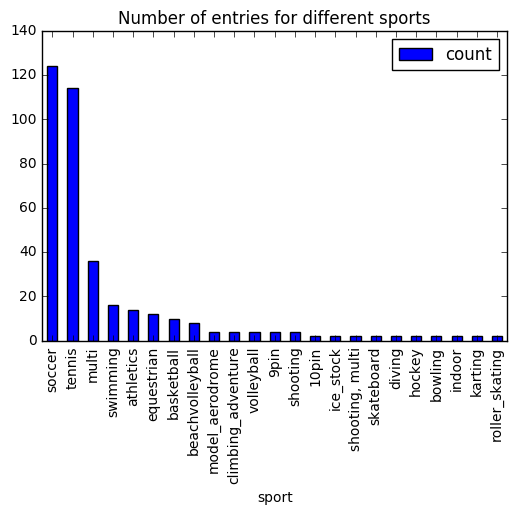

In [12]:

df = pd.DataFrame.from_records(sports, index="sport")
df.plot(kind="bar", title="Number of entries for different sports")

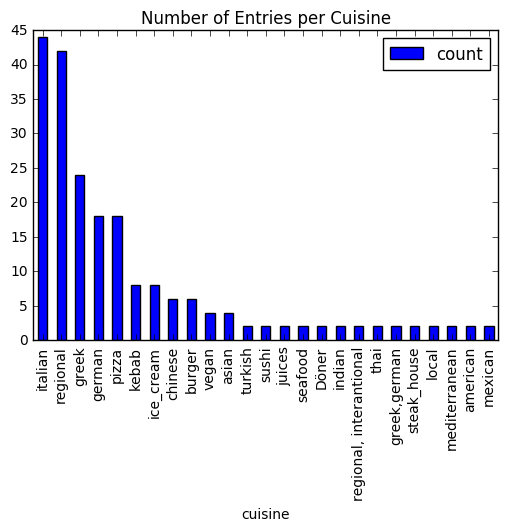

In [13]:
cuisine = aggregate(DB_HANDLE, [{"$match": {"cuisine": {"$exists":1}}},
                    {"$group": {"_id": "$cuisine", "count": {"$sum": 1}}},
                    {"$project": {"_id": 0, "cuisine": "$_id" , "count": "$count"}},
                    {"$sort": {"count": -1}}                                
                   ])
df = pd.DataFrame.from_records(cuisine, index="cuisine")
df.plot(kind="bar", title="Number of Entries per Cuisine")

### Religious Denominations
I know, that Franconia, the part of Bavaria Schwabach resides in, is with respect to the religion dominated by protestants, while the region around Munich is dominated by catholic people. The data shows, that there are more than twice as much protestant churches than catholic ones.

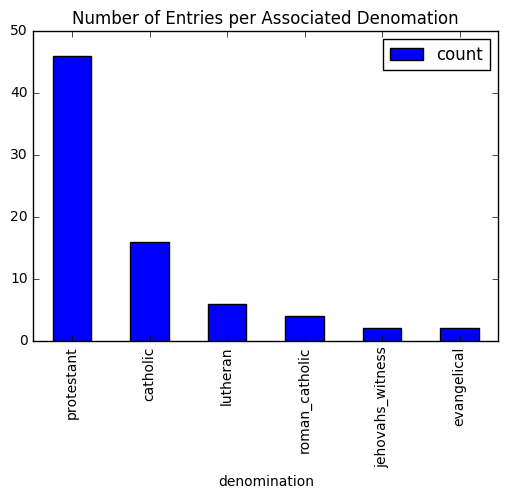

In [14]:
denomination = aggregate(DB_HANDLE, [{"$match": {"amenity": {"$eq": "place_of_worship"}, "denomination": {"$exists":1}}},
                    {"$group": {"_id": "$denomination", "count": {"$sum": 1}}},
                    {"$project": {"_id": 0, "denomination": "$_id" , "count": "$count"}},
                    {"$sort": {"count": -1}}                                
                   ])
df = pd.DataFrame.from_records(denomination, index="denomination")
df.plot(kind="bar", title="Number of Entries per Associated Denomation")

### Distribution of Kindergartens per City
I wanted to check which city has the most kindergarten in the region. Unfortunately, in the data some kindergarten do not come with an associated address. Despite this fact, Nuremberg and Schwabach seem to have a similar amount of kindergarten in the excerpt of the map that I investigated. I have to emphasize, that Nuremberg is only partly included in this dataset.

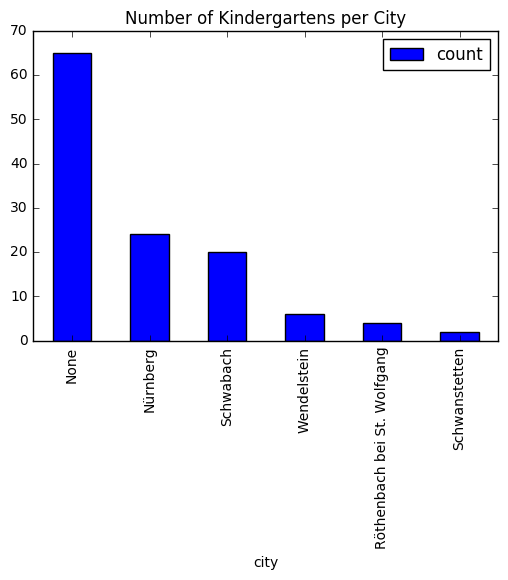

In [16]:
kindergarten = aggregate(DB_HANDLE, [{"$match": {"amenity": {"$eq":"kindergarten"}}},
                                     {"$group": {"_id": "$address.city", "count":{"$sum":1}}},
                                     {"$project": {"_id": 0, "city": "$_id" , "count": "$count"}},
                                     {"$sort": {"count": -1}}
                   ])
df = pd.DataFrame.from_records(kindergarten, index="city")
df.plot(kind="bar", title="Number of Kindergartens per City")

## Conclusion
Data from OpenStreetMap from around Schwabach is already in very good shape. The data base query for the numbers of kindergarten revealed that most of the kindergartens are missing addresses. An option could be to resolve the references to other nodes.